<img src="Images/atom.png" alt="Atom" style="width:60px" align="left" vertical-align="middle">

## 1. Introduction to hyperparameter tuning
*in Machine Learning*

----
We bet you were excited to build your first neural network model, train, and evaluate it. But usually the story doesn’t end there. Previously, we chose certain values for the following:
- The learning rate
- Number of batches
- Number of epochs
- Number of units per hidden layer
- Activation functions.

<br/>These are all *hyperparameters*. Why did we choose those numbers and values? Sometimes you start with a “hunch,” by looking at what other machine learning engineers often use in their solutions.

<br/>Almost any machine learning project you start will have the pipeline depicted in the diagram below.

<br/>First, we split data into the following sets:
- A *training set* to fit the model by updating the parameters (weights) of a neural network model. Previously, we randomly selected 67% (two thirds) of our data to be the training set.
- A *validation set* for checking the model’s fit. It is a biased evaluation since the model is modified based on its performance on this set. We haven’t set aside a validation set until now.
- A *test set* is used for an unbiased evaluation of the model. The test set should never be used for hyperparameter selection and tweaking! Rather, it is used to compare different models. For example, in Kaggle competitions, the leaderboard is determined based on the performance on a test set. Previously, we allocated 33% of the total data to be the test set.

<br/>Second, we set hyperparameters to some initial values. We fit the model to the training data and check how it performs on the validation data by looking at accuracy for classification or mean absolute error for regression. Finally, if the performance is not satisfactory, we change the hyperparameters and repeat the steps. Otherwise, we evaluate the final model on the test set and report the results.

<br/>What percentage of our data should we set aside for our training, validation, and test sets? Well, it depends on the amount of data you have and the task you are performing. Usually, machine learning engineers choose 70% of data for training, 20% for validating, and 10% for testing. But other splits are possible.

<br/>In the image below, you’ll see how we use the three datasets and our hyperparameters to adjust and evaluate our model’s performance:
- We use training data to adjust the weights and biases of our model to change its fit.
- We use validation data to evaluate the model’s performance.
- If the validation performance is good, we can use our test data to check if our model still performs well with a completely new set of data.
- If the validation performance isn’t good, we tweak our hyperparameters before retraining the model: the learning rate, batch size, number of epochs, number of hidden layers, optimizer.
<br/>
<img src="Images/Validation.png" style="width:1000px">

<img src="Images/atom.png" alt="Atom" style="width:60px" align="left" vertical-align="middle">

## 2. Using a validation set for hyperparameter tuning
*in Machine Learning*

----
Using the training data to choose hyperparameters might lead to overfitting to the training data meaning the model learns patterns specific to the training data that would not apply to new data. For that reason, hyperparameters are chosen on a held-out set called *validation set*. In TensorFlow Keras, validation split can be specified as a parameter in the `.fit()` function:

In [ ]:
my_model.fit(data, labels, epochs = 20, batch_size = 1, verbose = 1,  validation_split = 0.2)

where `validation_split` is a float between 0 and 1, denoting a fraction of the training data to be used as validation data. In the example above, 20% of the data would be allocated for validation. It is usually a small fraction of the training data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch.

<br/>*Exercise:*
<br/>Use the `.fit()` function to fit the model instance model to the training data `features_train` and training features `labels_train` with 50 `epochs`, batch size set to 8, verbose set to false (0), and validation split set to 20%.

In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.optimizers import Adam

'''A. IMPORT DATA'''
dataset = pd.read_csv('Data/insurance.csv') # 1. Import the data as a pandas dataframe.
features = dataset.iloc[:,0:6]  # 2. Dataframe slicing using iloc, this designates the first 6 rows as features (independent variables).
labels = dataset.iloc[:,-1] # 3. We select the last column with -1, which is designated as target variables (dependent variable).

'''B. DATA PRE-PROCESSING'''
features = pd.get_dummies(features) # 4. One-hot encoding for categorical variables.
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.33, random_state=42) # 5. Split the data into training (67%) and test (33%) data.
# ct = ColumnTransformer([('normalize', Normalizer(), ['age', 'bmi', 'children'])], remainder='passthrough') # 6a. Create a new ColumnTransformer instance and normalize the data (scale the numerical features to a fixed range, usually between 0 and 1).
ct = ColumnTransformer([('standardize', StandardScaler(), ['age', 'bmi', 'children'])], remainder='passthrough') # 6b. You may also standardize the data (rescale features to zero mean and unit variance).
features_train = ct.fit_transform(features_train) # 7. Fit the column transformer to the features_train DataFrame.
features_test = ct.transform(features_test) # 8. Transform the trained column transformer my_ct to the features_test DataFrame.

'''C. CREATE THE MODEL'''
def design_model(features):
    model = Sequential(name = "My_Sequential_Model") # 9. The most frequently used model in TensorFlow is Keras "Sequential". A sequential model allows us to create models layer-by-layer in a step-by-step fashion. 
    model.add(InputLayer(input_shape=(features.shape[1],))) # 10. Add the input layer. Notice that the input_shape parameter has to have its first dimension equal to the number of features (features.shape[1]) in the data. You don’t need to specify the second dimension: the number of samples or batch size.
    model.add(Dense(128, activation='relu')) # 11. Add a hidden layer with 128 neurons. With the activation parameter, we specify which activation function (ReLu) we want to have in the output of our hidden layer.
    model.add(Dense(1)) # 12. Add an output layer. The output layer shape depends on your task. In the case of regression, we need one output for each prediction required.
    opt = Adam(learning_rate=0.01) # 13. Optimize the model's weights using backpropagation, which refers to the computation of gradients with an algorithm known as gradient descent. Keras offers a variety of optimizers: SGD, Adam, RMSprop, and others. Also determine the learning rate.
    model.compile(loss='mse', metrics=['mae'], optimizer=opt) # 14. Compile an instance of the model. "loss" denotes the measure of learning success and is inversely proportional to performance. The most commonly used loss function is the Mean Squared Error (mse).
    return model

'''D. TRAIN THE MODEL'''
model = design_model(features_train) # 15. Construct the model
model.fit(features_train, labels_train, epochs=50, batch_size=3, verbose=0, validation_split=0.33) # 16. Fit the model using 50 epochs and batch size 1.

'''E. TEST/PLOT THE MODEL'''
val_mse, val_mae = model.evaluate(features_test, labels_test, verbose=0) # 17. Evaluate the model on the test data.
print("MAE: ", val_mae)  # 18. We want to observe the progress of the Mean Absolute Error (mae) while training the model because MAE can give us a better idea than mse on how far off we are from the true values in the units we are predicting.





MAE:  3428.53515625


<img src="Images/atom.png" alt="Atom" style="width:60px" align="left" vertical-align="middle">

## 3. Manual tuning: learning rate
*in Machine Learning*

----
Neural networks are trained with the gradient descent algorithm and one of the most important hyperparameters in the network training is the *learning rate*. The learning rate determines how big of a change you apply to the network weights as a consequence of the error gradient calculated on a batch of training data.

<br/>A larger learning rate leads to a faster learning process at a cost to be stuck in a suboptimal solution (local minimum). A smaller learning rate might produce a good suboptimal or global solution, but it will take it much longer to converge. In the extremes, a learning rate too large will lead to an unstable learning process oscillating over the epochs. A learning rate too small may not converge or get stuck in a local minimum.

<br/>It can be helpful to test different learning rates as we change our hyperparameters. A learning rate of 1.0 leads to oscillations, 0.01 may give us a good performance, while 1e-07 is too small and almost nothing is learned within the allotted time.

<br/>*Exercise:*
<br/>In the code below, we created a list of different learning rates we would like to check. For each learning rate, we fit the model and plot the loss on the training set (orange) and the validation set (blue).

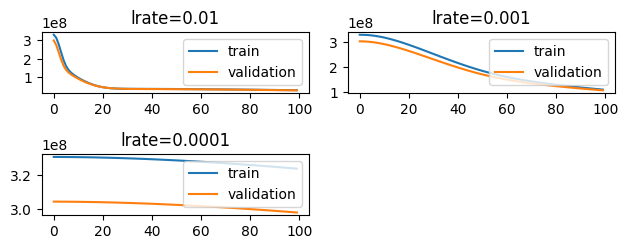

In [2]:
import matplotlib.pyplot as plt

'''C. CREATE THE MODEL'''
def design_model(features, learning_rate):
    model = Sequential(name = "My_Sequential_Model") # 9. The most frequently used model in TensorFlow is Keras "Sequential". A sequential model allows us to create models layer-by-layer in a step-by-step fashion. 
    model.add(InputLayer(input_shape=(features.shape[1],))) # 10. Add the input layer. Notice that the input_shape parameter has to have its first dimension equal to the number of features (features.shape[1]) in the data. You don’t need to specify the second dimension: the number of samples or batch size.
    model.add(Dense(128, activation='relu')) # 11. Add a hidden layer with 128 neurons. With the activation parameter, we specify which activation function (ReLu) we want to have in the output of our hidden layer.
    model.add(Dense(1)) # 12. Add an output layer. The output layer shape depends on your task. In the case of regression, we need one output for each prediction required.
    opt = Adam(learning_rate=learning_rate) # 13. Optimize the model's weights using backpropagation, which refers to the computation of gradients with an algorithm known as gradient descent. Keras offers a variety of optimizers: SGD, Adam, RMSprop, and others. Also determine the learning rate.
    model.compile(loss='mse', metrics=['mae'], optimizer=opt) # 14. Compile an instance of the model. "loss" denotes the measure of learning success and is inversely proportional to performance. The most commonly used loss function is the Mean Squared Error (mse).
    return model

'''D. TRAIN THE MODEL'''
def fit_model(f_train, l_train, learning_rate, num_epochs, bs):
    # Build the model
    model = design_model(f_train, learning_rate)
    # Train the model on the training data
    history = model.fit(f_train, l_train, epochs = num_epochs, batch_size = bs, verbose = 0, validation_split = 0.2)
    # Plot learning curves
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('lrate=' + str(learning_rate))
    plt.legend(loc="upper right")

'''E. TEST/PLOT THE MODEL'''
# Make a list of learning rates to try out
learning_rates = [0.01, 0.001, 0.0001]
# Fixed number of epochs
num_epochs = 100
# Fixed number of batches
batch_size = 10 

for i in range(len(learning_rates)):
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    fit_model(features_train, labels_train, learning_rates[i], num_epochs, batch_size)

plt.tight_layout()
plt.show()

<img src="Images/atom.png" alt="Atom" style="width:60px" align="left" vertical-align="middle">

## 4. Manual tuning: batch size
*in Machine Learning*

----
The *batch size* is a hyperparameter that determines how many training samples are seen before updating the network’s parameters (weight and bias matrices).

<br/>When the batch contains all the training examples, the process is called batch gradient descent. If the batch has one sample, it is called the stochastic gradient descent. And finally, when 1 < batch size < number of training points, is called mini-batch gradient descent. An advantage of using batches is for GPU computation that can parallelize neural network computations.

<br/>How do we choose the batch size for our model? On one hand, a larger batch size will provide our model with better gradient estimates and a solution close to the optimum, but this comes at a cost of computational efficiency and good generalization performance. On the other hand, smaller batch size is a poor estimate of the gradient, but the learning is performed faster. Finding the “sweet spot” depends on the dataset and the problem, and can be determined through hyperparameter tuning.

<br/>For this experiment, we fix the learning rate to 0.01 and try the following batch sizes: 1, 2, 4, 10, 16, 32 and 64. Notice how small batch sizes have a larger variance (more oscillation in the learning curve).

<br/>Want to improve the performance with a larger batch size? A good trick is to increase the learning rate!

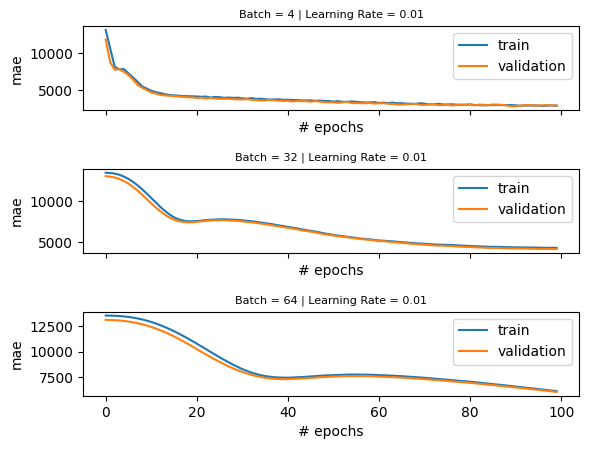

In [3]:
import matplotlib.pyplot as plt

'''D. TRAIN THE MODEL'''
def fit_model(f_train, l_train, learning_rate, num_epochs, batch_size, ax):
    model = design_model(features_train, learning_rate)
    # Train the model on the training data
    history = model.fit(features_train, labels_train, epochs=num_epochs, batch_size = batch_size, verbose=0, validation_split = 0.3)
    # Plot learning curves
    ax.plot(history.history['mae'], label='train')
    ax.plot(history.history['val_mae'], label='validation')
    ax.set_title(f"Batch = {batch_size} | Learning Rate = {learning_rate}", fontdict={'fontsize': 8, 'fontweight': 'medium'})
    ax.set_xlabel('# epochs')
    ax.set_ylabel('mae')
    ax.legend()

# Fixed learning rate 
learning_rate = 0.01 
# Fixed number of epochs
num_epochs = 100
# We choose a number of batch sizes to try out
batches = [4, 32, 64] 

'''E. TEST/PLOT THE MODEL'''
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex='col', sharey='row', gridspec_kw={'hspace': 0.7, 'wspace': 0.4}) #preparing axes for plotting
axes = [ax1, ax2, ax3]

# Iterate through all the batch values
for i in range(len(batches)): fit_model(features_train, labels_train, learning_rate, num_epochs, batches[i], axes[i])

<br/>*Exercise:*
<br/>In the previous checkpoint, you might have noticed bad performance for larger batch sizes (32 and 64). When having performance issues with larger batches it might help to increase the learning rate. Modify the value for the learning rate by assigning 0.1 to the `learning_rate` variable. Rerun the code and observe the plots.

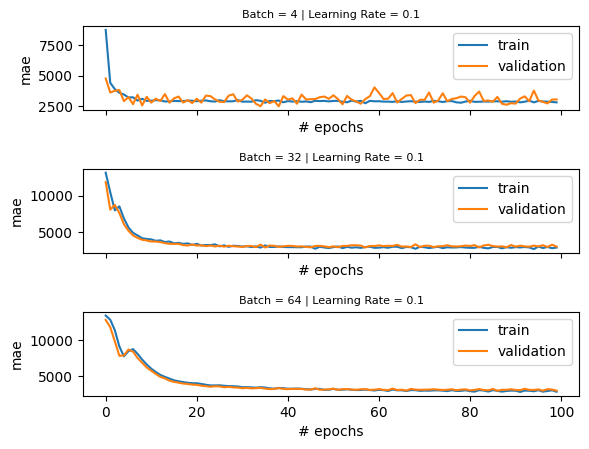

In [4]:
# Fixed learning rate 
learning_rate = 0.1 
# Fixed number of epochs
num_epochs = 100
# We choose a number of batch sizes to try out
batches = [4, 32, 64] 

'''E. TEST/PLOT THE MODEL'''
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex='col', sharey='row', gridspec_kw={'hspace': 0.7, 'wspace': 0.4}) #preparing axes for plotting
axes = [ax1, ax2, ax3]

# Iterate through all the batch values
for i in range(len(batches)): fit_model(features_train, labels_train, learning_rate, num_epochs, batches[i], axes[i])

<img src="Images/atom.png" alt="Atom" style="width:60px" align="left" vertical-align="middle">

## 5. Manual tuning: epochs and early stopping
*in Machine Learning*

----
Being an iterative process, gradient descent iterates many times through the training data. The number of *epochs* is a hyperparameter representing the number of complete passes through the training dataset. This is typically a large number (100, 1000, or larger). If the data is split into batches, in one epoch the optimizer will see all the batches.

<br/>How do you choose the number of epochs? Too many epochs can lead to overfitting, and too few to underfitting. One trick is to use *early stopping*: when the training performance reaches the plateau or starts degrading, the learning stops.

<br/>To illustrate we can introduce some overfitting by increasing the number of parameters in the neural network model and get the following plot:
<img src="Images/Early_stop.png" style="width:500px">

<br/>We know we are overfitting because the validation error at first decreases but eventually starts increasing. The final validation MAE is ~3034, while the training MAE is ~1000. That’s a big difference. We see that the training could have been stopped earlier (around epoch 50).

<br/>We can specify early stopping in TensorFlow with Keras by creating an `EarlyStopping` callback and adding it as a parameter when we fit our model.

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
history = model.fit(features_train, labels_train, epochs=num_epochs, batch_size=16, verbose=0, validation_split=0.2, callbacks=[stop])

Here, we include the following:
- `monitor = val_loss`, which means we are monitoring the validation loss to decide when to stop the training
- `mode = min`, which means we seek minimal loss
- `patience = 40`, which means that if the learning reaches a plateau, it will continue for 40 more epochs in case the plateau leads to improved performance

<br/>*Exercise:*
1. In the `fit_model()` method, just before calling `model.fit()`, create an instance of `EarlyStopping` that monitors the validation loss (`val_loss`), seeks minimal loss, that is verbose, and has `patience` equal to 20. Assign the result to a variable called `stop`.
2. Now that you have an instance of `EarlyStopping` assigned to `stop`, you need to pass the instance as a callback function to the `.fit()` method. We left an empty list for you there: `callback = []`. Put `stop` as a single element in the `callback`. Run the code. The early stopping epoch should be 47. Please verify.

Epoch 44: early stopping
Final training MAE: 2921.25341796875
Final validation MAE: 2773.452880859375


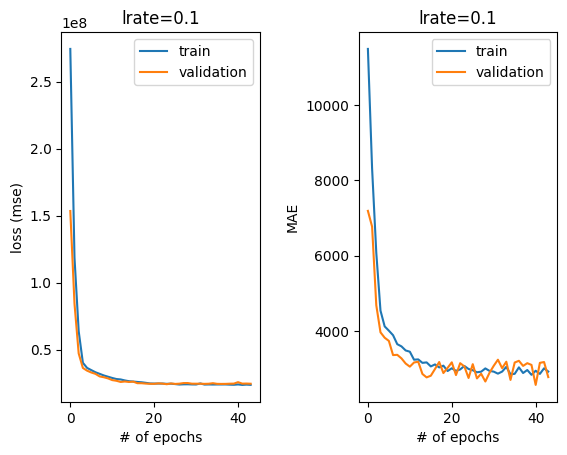

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

'''D. TRAIN THE MODEL'''
def fit_model(f_train, l_train, learning_rate, num_epochs, batch_size):
    model = design_model(features_train, learning_rate)
    # Your code here
    stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    # Train the model on the training data
    history = model.fit(features_train, labels_train, epochs=num_epochs, batch_size = batch_size, verbose=0, validation_split = 0.2, callbacks=[stop]) 
    return history

# Train the model
learning_rate=0.1
num_epochs=500
batch_size=16
history = fit_model(features_train, labels_train, learning_rate, num_epochs, batch_size)

'''E. TEST/PLOT THE MODEL'''
fig, axs = plt.subplots(1, 2, gridspec_kw={'hspace': 1, 'wspace': 0.5}) 
(ax1, ax2) = axs
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='validation')
ax1.set_title('lrate=' + str(learning_rate))
ax1.legend(loc="upper right")
ax1.set_xlabel("# of epochs")
ax1.set_ylabel("loss (mse)")

ax2.plot(history.history['mae'], label='train')
ax2.plot(history.history['val_mae'], label='validation')
ax2.set_title('lrate=' + str(learning_rate))
ax2.legend(loc="upper right")
ax2.set_xlabel("# of epochs")
ax2.set_ylabel("MAE")

print("Final training MAE:", history.history['mae'][-1])
print("Final validation MAE:", history.history['val_mae'][-1])

<img src="Images/atom.png" alt="Atom" style="width:60px" align="left" vertical-align="middle">

## 6. Manual tuning: changing the model
*in Machine Learning*

----
We saw in the previous exercise that if you have a big model and you train too long, you might overfit. Let us see the opposite - having a too simple model.

<br/>In the code on the right, we compare a one-layer neural network and a model with a single hidden layer. The models look like this:

In [10]:
# One layer model
def one_layer_model(X, learning_rate):
    ...
    model.add(input) 
    model.add(layers.Dense(1))
    ...

# More complex model
def more_complex_model(X, learning_rate):
    ...
    model.add(input)
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))

When we run the learning we get the learning curves depicted on the far right.

<br/>If you observe Plot #1 for the model with no hidden layers you will see an issue: the validation curve is below the training curve. This means that the training curve can get better at some point, but the model complexity doesn’t allow it. This phenomenon is called underfitting. You can also notice that no early stopping occurs here since the performance of this model is bad all the time.

<br/>Plot #2 is for the model with a single hidden layer. You can observe a well-behaving curve with the early stopping at epoch 38 and we have a much better result. Nice!

<br/>How do we choose the number of hidden layers and the number of units per layer? That is a tough question and there is no good answer. The rule of thumb is to start with one hidden layer and add as many units as we have features in the dataset. However, this might not always work. We need to try things out and observe our learning curve.

Results of a one layer model:
Final training MAE: 7392.1650390625
Final validation MAE: 7083.490234375
Results of a model with hidden layers:
Epoch 48: early stopping
Final training MAE: 2901.4560546875
Final validation MAE: 2677.0771484375


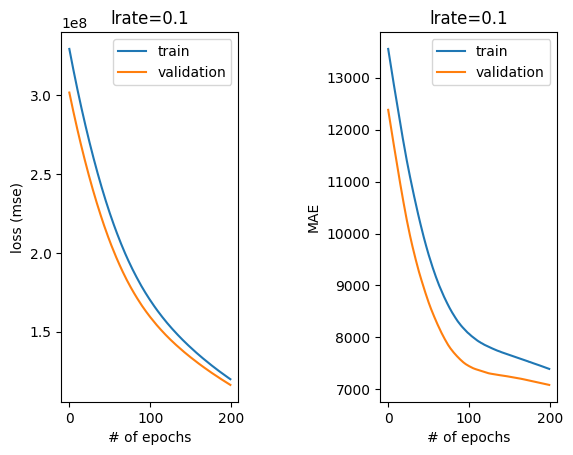

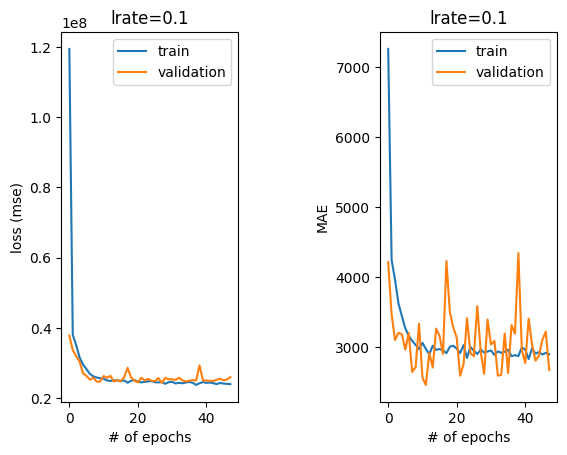

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

'''C. CREATE THE MODEL'''
def more_complex_model(X, learning_rate):
    model = Sequential(name="more_complex_model")
    model.add(tf.keras.Input(shape=(X.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(loss='mse', metrics=['mae'], optimizer=opt)
    return model

def one_layer_model(X, learning_rate):
    model = Sequential(name="one_layer_model")
    model.add(tf.keras.Input(shape=(X.shape[1],)))
    model.add(layers.Dense(1))
    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(loss='mse', metrics=['mae'], optimizer=opt)
    return model

'''D. TRAIN THE MODEL'''
def fit_model(model, f_train, l_train, learning_rate, num_epochs):
    #train the model on the training data
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)
    history = model.fit(features_train, labels_train, epochs=num_epochs, batch_size= 2, verbose=0, validation_split = 0.2, callbacks = [es])
    return history

'''E. TEST/PLOT THE MODEL'''
def plot(history):
    # plot learning curves
    fig, axs = plt.subplots(1, 2, gridspec_kw={'hspace': 1, 'wspace': 0.8}) 
    (ax1, ax2) = axs
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='validation')
    ax1.set_title('lrate=' + str(learning_rate))
    ax1.legend(loc="upper right")
    ax1.set_xlabel("# of epochs")
    ax1.set_ylabel("loss (mse)")

    ax2.plot(history.history['mae'], label='train')
    ax2.plot(history.history['val_mae'], label='validation')
    ax2.set_title('lrate=' + str(learning_rate))
    ax2.legend(loc="upper right")
    ax2.set_xlabel("# of epochs")
    ax2.set_ylabel("MAE")
    print("Final training MAE:", history.history['mae'][-1])
    print("Final validation MAE:", history.history['val_mae'][-1])

learning_rate = 0.1
num_epochs = 200

#fit the more simple model
print("Results of a one layer model:")
history1 = fit_model(one_layer_model(features_train, learning_rate), features_train, labels_train, learning_rate, num_epochs)
plot(history1)

#fit the more complex model
print("Results of a model with hidden layers:")
history2 = fit_model(more_complex_model(features_train, learning_rate), features_train, labels_train, learning_rate, num_epochs)
plot(history2)

<img src="Images/atom.png" alt="Atom" style="width:60px" align="left" vertical-align="middle">

## 7. Towards automated tuning: grid and random search
*in Machine Learning*

----
So far we’ve been manually setting and adjusting hyperparameters to train and evaluate our model. If we didn’t like the result, we changed the hyperparameters to some other values. However, this is rather cumbersome; it would be nice if we could make these changes in a systematic and automated way. Fortunately, there are some strategies for automated hyperparameter tuning, including the following two.

<br/>*Grid search, or exhaustive search,* tries every combination of desired hyperparameter values. If, for example, we want to try learning rates of 0.01 and 0.001 and batch sizes of 10, 30, and 50, grid search will try six combinations of parameters (0.01 and 10, 0.01 and 30, 0.01 and 50, 0.001 and 10, and so on). This obviously gets very computationally demanding when we increase the number of values per hyperparameter or the number of hyperparameters we want to tune.

<br/>On the other hand, *Random Search* goes through random combinations of hyperparameters and doesn’t try them all.

### 7a. Grid search in Keras
To use `GridSearchCV` from scikit-learn for regression we need to first wrap our neural network model into a `KerasRegressor`:

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor

model = KerasRegressor(build_fn=design_model)

Then we need to setup the desired hyperparameters grid (we don’t use many values for the sake of speed):

In [8]:
batch_size = [10, 40]
epochs = [10, 50]
param_grid = dict(batch_size=batch_size, epochs=epochs)

Finally, we initialize a `GridSearchCV` object and fit our model to the data:

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=make_scorer(mean_squared_error, greater_is_better=False))
grid_result = grid.fit(features_train, labels_train, verbose=0)

Notice that we initialized the scoring parameter with scikit-learn’s `.make_scorer()` method. We’re evaluating our hyperparameter combinations with a mean squared error making sure that `greater_is_better` is set to `False` since we are searching for a set of hyperparameters that yield us the smallest error.

### 7b. Randomized search in Keras
We first change our hyperparameter grid specification for the randomized search in order to have more options:

In [ ]:
param_grid = {'batch_size': sp_randint(2, 16), 'nb_epoch': sp_randint(10, 100)}

Randomized search will sample values for `batch_size` and `nb_epoch` from uniform distributions in the interval [2, 16] and [10, 100], respectively, for a fixed number of iterations. In our case, 12 iterations:

In [ ]:
grid = RandomizedSearchCV(estimator = model, param_distributions=param_grid, scoring = make_scorer(mean_squared_error, greater_is_better=False), n_iter = 12)

We cover only simpler cases here, but you can set up `GridSearchCV` and `RandomizedSearchCV` to tune over any hyperparameters you can think of: optimizers, number of hidden layers, number of neurons per layer, and so on.

In [15]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error, make_scorer

'''C. CREATE THE MODEL'''
def design_model(features):
    model = Sequential(name = "My_Sequential_Model") # 9. The most frequently used model in TensorFlow is Keras "Sequential". A sequential model allows us to create models layer-by-layer in a step-by-step fashion. 
    model.add(InputLayer(input_shape=(features.shape[1],))) # 10. Add the input layer. Notice that the input_shape parameter has to have its first dimension equal to the number of features (features.shape[1]) in the data. You don’t need to specify the second dimension: the number of samples or batch size.
    model.add(Dense(128, activation='relu')) # 11. Add a hidden layer with 128 neurons. With the activation parameter, we specify which activation function (ReLu) we want to have in the output of our hidden layer.
    model.add(Dense(1)) # 12. Add an output layer. The output layer shape depends on your task. In the case of regression, we need one output for each prediction required.
    opt = Adam(learning_rate=0.01) # 13. Optimize the model's weights using backpropagation, which refers to the computation of gradients with an algorithm known as gradient descent. Keras offers a variety of optimizers: SGD, Adam, RMSprop, and others. Also determine the learning rate.
    model.compile(loss='mse', metrics=['mae'], optimizer=opt) # 14. Compile an instance of the model. "loss" denotes the measure of learning success and is inversely proportional to performance. The most commonly used loss function is the Mean Squared Error (mse).
    return model

'''D. OPTIMIZE THE MODEL: GRID SEARCH'''
def do_grid_search():
    batch_size = [6, 64]
    epochs = [10, 30, 61]
    model = KerasRegressor(model=design_model, features=features_train) # KerasRegressor expects a function and not the model
    param_grid = dict(batch_size=batch_size, epochs=epochs)
    grid = GridSearchCV(estimator = model, param_grid=param_grid, scoring = make_scorer(mean_squared_error, greater_is_better=False), return_train_score=True)
    grid_result = grid.fit(features_train, labels_train, verbose = 0)
    # print(grid_result)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params): 
        # print("%f (%f) with: %r" % (mean, stdev, param))
        pass

    # print("Traininig")
    means = grid_result.cv_results_['mean_train_score']
    stds = grid_result.cv_results_['std_train_score']
    for mean, stdev, param in zip(means, stds, params): 
        # print("%f (%f) with: %r" % (mean, stdev, param))
        pass

'''D. OPTIMIZE THE MODEL: RANDOMIZED SEARCH'''
def do_randomized_search():
    param_grid = {'batch_size': sp_randint(2, 16), 'epochs': sp_randint(10, 100)}
    model = KerasRegressor(model=design_model, features=features_train) # KerasRegressor expects a function and not the model
    grid = RandomizedSearchCV(estimator = model, param_distributions=param_grid, scoring = make_scorer(mean_squared_error, greater_is_better=False), n_iter = 12)
    grid_result = grid.fit(features_train, labels_train, verbose = 0)
    # print(grid_result)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params): 
        # print("%f (%f) with: %r" % (mean, stdev, param))
        pass

print("-------------- GRID SEARCH --------------------")
do_grid_search()
print("-------------- RANDOMIZED SEARCH --------------------")
do_randomized_search()

-------------- GRID SEARCH --------------------
12/12 [==============================] - 0s 725us/step
Best: -32130061.606976 using {'batch_size': 6, 'epochs': 61}
-65593238.440307 (4730664.384018) with: {'batch_size': 6, 'epochs': 10}
-36679509.876472 (3643382.895606) with: {'batch_size': 6, 'epochs': 30}
-32130061.606976 (3440579.483394) with: {'batch_size': 6, 'epochs': 61}
-301104773.181995 (30159230.873147) with: {'batch_size': 64, 'epochs': 10}
-152973275.386041 (20999195.389810) with: {'batch_size': 64, 'epochs': 30}
-91668629.364845 (9315015.848221) with: {'batch_size': 64, 'epochs': 61}
-------------- RANDOMIZED SEARCH --------------------
20/20 [==============================] - 0s 741us/step
Best: -24951010.822213 using {'batch_size': 2, 'epochs': 83}


<img src="Images/atom.png" alt="Atom" style="width:60px" align="left" vertical-align="middle">

## 8. Regularization: dropout
*in Machine Learning*

----
*Regularization* is a set of techniques that prevent the learning process to completely fit the model to the training data which can lead to overfitting. It makes the model simpler, smooths out the learning curve, and hence makes it more ‘regular’. There are many techniques for regularization such as simplifying the model, adding weight regularization, weight decay, and so on. The most common regularization method is dropout.

<br/>Dropout is a technique that randomly ignores, or “drops out” a number of outputs of a layer by setting them to zeros. The dropout rate is the percentage of layer outputs set to zero (usually between 20% to 50%).

<br/>In Keras, we can add a dropout layer by introducing the `Dropout` layer.

<br/>Let’s recreate our overfitting network having too many layers and too many neurons per layer in the `design_model_no_dropout()` method. For this model, we get the learning curve depicted in Figure 1. The validation error gets worse, which indicates the trend of overfitting.

<br/>Next, we introduce dropout layers in the `design_model_dropout()` method. Our model looks like this:

In [ ]:
model.add(input)
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(24, activation = 'relu'))
#your code here!
model.add(layers.Dense(1))

For this model, we get the learning curve in Figure 2. The validation MAE we get with the dropout is lower than without it. Note that the validation error is also lower than the training error in this case. One of the explanations might be that the dropout is used only during training, and the full network is used during the validation/testing with layers’ output scaled down by the dropout rate.

<br/>*Exercise:*
<br/>In the `design_model_dropout()` method, after the hidden layer with 24 neurons, add another dropout method as an instance of `tensorflow.keras.layers.Dropout` with the dropout rate set to 0.3.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from plotting import plot
import matplotlib.pyplot as plt

def design_model_dropout(X, learning_rate):
    model = Sequential(name="my_first_model")
    input = tf.keras.Input(shape=(X.shape[1],))
    model.add(input)
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(24, activation='relu'))
    #------your code here!------
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1))
    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(loss='mse', metrics=['mae'], optimizer=opt)
    return model

def design_model_no_dropout(X, learning_rate):
    model = Sequential(name="my_first_model")
    input = layers.InputLayer(input_shape=(X.shape[1],))
    model.add(input)
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(24, activation='relu'))
    model.add(layers.Dense(1))
    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(loss='mse', metrics=['mae'], optimizer=opt)
    return model
    
#using the early stopping in fit_model
learning_rate = 0.001
num_epochs = 200
#train the model without dropout
history1 = fit_model(design_model_no_dropout(features_train, learning_rate), features_train, labels_train, learning_rate, num_epochs)
#train the model with dropout
history2 = fit_model(design_model_dropout(features_train, learning_rate), features_train, labels_train, learning_rate, num_epochs)

<img src="Images/dropout.png" style="width:400px">

<img src="Images/atom.png" alt="Atom" style="width:60px" align="left" vertical-align="middle">

## 9. Baselines: how to know the performance is reasonable?
*in Machine Learning*

----
Why do we need a *baseline*? For example, we have data consisting of 90% dog images, and 10% cat images. An algorithm that predicts the majority class for each data point, will have 90% accuracy on this dataset! That might sound good, but predicting the majority class is hardly a useful classifier. We need to perform better.

<br/>A baseline result is the simplest possible prediction. For some problems, this may be a random result, and for others, it may be the most common class prediction. Since we are focused on a regression task in this lesson, we can use averages or medians of the class distribution known as central tendency measures as the result for all predictions.

<br/>Scikit-learn provides `DummyRegressor`, which serves as a baseline regression algorithm. We’ll choose mean (average) as our central tendency measure.

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, labels_train)
y_pred = dummy_regr.predict(features_test)
MAE_baseline = mean_absolute_error(labels_test, y_pred)
print(MAE_baseline)

The result of the baseline is \\$9,190, and we definitely did better than this (around \\$3,000) in our previous experiments in this lesson.

<img src="Images/atom.png" alt="Atom" style="width:60px" align="left" vertical-align="middle">

## 10. Summary
*in Machine Learning*

----
In this lesson, you learned how to both manually and automatically choose hyperparameters of the neural network training procedure in order to select a model with the best predictive performance on a validation set. The hyperparameters we covered in this lesson are
- learning rate
- batch size
- number of epochs
- model size (number of hidden layers/neurons and number of parameters)
- regularization (dropout)

<br/>We discussed the concepts of underfitting (having a too simple model to capture data patterns) and overfitting (having a model with too many parameters that learns the training data too well and is unable to generalize). We discussed methods to combat overfitting such as regularization. To avoid underfitting we increased the complexity of our model.

<br/>Besides data preprocessing, hyperparameter tuning is probably the most costly and intensive process of neural network training. We covered how to set up grid seach and randomized search in Keras in order to automate the process of hyperparameter tuning.

<br/>We also showed you how to check the performance of your model against a simple baseline. Baselines give you an idea of whether your model has a reasonable performance.

<br/>In the end, we hope you see how all of the hyperparameters interplay and how they can influence the performance of the network.

<br/>*Exercise: put it all together!*

In [15]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error, make_scorer

'''A. IMPORT DATA'''
dataset = pd.read_csv('Data/insurance.csv') # 1. Import the data as a pandas dataframe.
features = dataset.iloc[:,0:6]  # 2. Dataframe slicing using iloc, this designates the first 6 rows as features (independent variables).
labels = dataset.iloc[:,-1] # 3. We select the last column with -1, which is designated as target variables (dependent variable).

'''B. DATA PRE-PROCESSING'''
features = pd.get_dummies(features) # 4. One-hot encoding for categorical variables.
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.33, random_state=42) # 5. Split the data into training (67%) and test (33%) data.
# ct = ColumnTransformer([('normalize', Normalizer(), ['age', 'bmi', 'children'])], remainder='passthrough') # 6a. Create a new ColumnTransformer instance and normalize the data (scale the numerical features to a fixed range, usually between 0 and 1).
ct = ColumnTransformer([('standardize', StandardScaler(), ['age', 'bmi', 'children'])], remainder='passthrough') # 6b. You may also standardize the data (rescale features to zero mean and unit variance).
features_train = ct.fit_transform(features_train) # 7. Fit the column transformer to the features_train DataFrame.
features_test = ct.transform(features_test) # 8. Transform the trained column transformer my_ct to the features_test DataFrame.

'''C. CREATE THE MODEL'''
def design_model(features, activation = 'relu', hidden_layers=2):
    model = Sequential(name = "My_Sequential_Model") # 9. The most frequently used model in TensorFlow is Keras "Sequential". A sequential model allows us to create models layer-by-layer in a step-by-step fashion. 
    model.add(InputLayer(input_shape=(features.shape[1],))) # 10. Add the input layer. Notice that the input_shape parameter has to have its first dimension equal to the number of features (features.shape[1]) in the data. You don’t need to specify the second dimension: the number of samples or batch size.
    for i in range(hidden_layers): 
        model.add(Dense(128, activation=activation)) # 11. Add a number of hidden layers with 128 neurons. With the activation parameter, we specify which activation function (ReLu) we want to have in the output of our hidden layer.
        model.add(Dropout(0.2)) # 12. Regularization is a set of techniques that prevent the learning process to completely fit the model to the training data which can lead to overfitting. Dropout is a technique that randomly ignores/“drops out” a number of outputs of a layer by setting them to zeros. 
    model.add(Dense(1)) # 13. Add an output layer. The output layer shape depends on your task. In the case of regression, we need one output for each prediction required. 
    opt = Adam(learning_rate=0.01) # 14. Optimize the model's weights using backpropagation, which refers to the computation of gradients with an algorithm known as gradient descent. Keras offers a variety of optimizers: SGD, Adam, RMSprop, and others. Also determine the learning rate.
    model.compile(loss='mse', metrics=['mae'], optimizer=opt) # 15. Compile an instance of the model. "loss" denotes the measure of learning success and is inversely proportional to performance. The most commonly used loss function is the Mean Squared Error (mse).
    return model

'''D. OPTIMIZE THE MODEL: GRID SEARCH'''
def do_grid_search():
    model = KerasRegressor(model=design_model, features=features_train) # KerasRegressor expects a function and not the model
    param_grid = dict(batch_size=[6, 64], epochs=[10, 30, 61])
    grid = GridSearchCV(estimator = model, param_grid=param_grid, scoring = make_scorer(mean_squared_error, greater_is_better=False), return_train_score=True)
    grid_result = grid.fit(features_train, labels_train, verbose = 0)
    print(f"GRID SEARCH => Best: {grid_result.best_score_} using {grid_result.best_params_}")
    return grid_result.best_params_

'''D. OPTIMIZE THE MODEL: RANDOMIZED SEARCH'''
def do_randomized_search(): 
    param_grid = {'batch_size': sp_randint(2, 16), 'epochs': sp_randint(10, 50)}
    model = KerasRegressor(model=design_model, features=features_train) # KerasRegressor expects a function and not the model
    grid = RandomizedSearchCV(estimator = model, param_distributions=param_grid, scoring = make_scorer(mean_squared_error, greater_is_better=False), n_iter = 20)
    grid_result = grid.fit(features_train, labels_train, verbose = 0)
    print(f"RANDOMIZED SEARCH => Best: {grid_result.best_score_} using {grid_result.best_params_}")

best_params = do_grid_search() # 16a. Optimize the model's hyperparameters using the Grid Search method
#best_params = do_randomized_search() # 16b. Optimize the model's hyperparameters using the Randomized Search method

'''E. TRAIN THE MODEL'''
model = design_model(features_train) # 17. Construct the model
# 18. Fit model using optimized epochs & batch size. When the training performance reaches the plateau or starts degrading, the learning stops.
model.fit(features_train, labels_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0, validation_split=0.33, callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)])

'''F. TEST/PLOT THE MODEL'''
val_mse, val_mae = model.evaluate(features_test, labels_test, verbose=0) # 19. Evaluate the model on the test data.
print("MAE: ", val_mae)  # 20. We want to observe the progress of the Mean Absolute Error (mae) while training the model because MAE can give us a better idea than mse on how far off we are from the true values in the units we are predicting.

12/12 [==============================] - 0s 726us/step
GRID SEARCH => Best: -25402311.603451468 using {'batch_size': 6, 'epochs': 30}
MAE:  3015.323486328125
